# Insight Data Science Seattle Interview Demo

# Project: predict if a new user of Airbnb will make a booking

## Outline:

1. Pose a question: Is a new user going to make a booking on Airbnb?
2. Prepare a relevant data set
3. Select metrics to measure model performance
4. Exploratory data analysis: Visualization/ Preprocessing/ Feature extraction
5. Build a predictive model

### 1. Define goal

Build a model to predict if a new user will make a booking on Airbnb. I am curious to find out if we could use information about a user to make predictions and the model if developed well could also be valuable for Airbnb decide how to do marketing, advertisement.

### 2. Prepare data set

Data for this project are downloaded from the Kaggle competition website:
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data

Out of the full data set, I chose 5 features that I think are most relevant to analyze. They are:
- `age`
- `gender`
- `date_account_created`. These are the date on which users created their accounts. 
- `signup_app`. These are applications through which the users signed up.
- `affiliation_channel`. This is the kind of paid marketing that a user is brought by. For example, SEM means search engine marketing.

Users dataset contains information of users that created their account between July 1, 2012 and July 1, 2014. This covers two years which could capture seasonality variations. Also, there's plenty of time between those date to Dec 5, 2015 when the dataset is uploaded and this allows ample time for the users to make a booking (even though it's still possible that some of the later registered user that haven't yet make a booking but will do in the future).

In [1]:
import warnings
warnings.filterwarnings('ignore')    # suppress warnings for clean demo

pd.set_option('display.max_rows', None)    #don't hide any rows or columns when display
pd.set_option('display.max_columns', None)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from scipy import sparse
from sklearn.cross_validation import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import GridSearchCV

#### Load Datasets

In [3]:
users_data = pd.read_csv("airbnb_short.csv")

In [4]:
num_rows, num_cols = users_data.shape
print("There are {:,} rows and {:,} columns in the train_users data.".format(num_rows, num_cols))

There are 183,537 rows and 7 columns in the train_users data.


In [5]:
users_data.head(3)

,id,date_account_created,gender,age,affiliate_channel,signup_app,Booking
0,oamfblpxdy,2014-01-15,OTHER,45.0,direct,Moweb,True
1,5p0nmf3r6i,2014-05-23,FEMALE,39.0,direct,Web,False
2,dlg3a9x97v,2014-04-03,MALE,47.0,sem-brand,Web,False


In [6]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183537 entries, 0 to 183536
Data columns (total 7 columns):
id                      183537 non-null object
date_account_created    183537 non-null object
gender                  183537 non-null object
age                     105383 non-null float64
affiliate_channel       183537 non-null object
signup_app              183537 non-null object
Booking                 183537 non-null bool
dtypes: bool(1), float64(1), object(5)
memory usage: 8.6+ MB


*Findings:*
- *Most of the columns are categorical variable.* 
- *`Age` has a lot of missing values.*

##### Basic summary of  `Booking`

In [7]:
users_data['Booking'].value_counts()/float(users_data.shape[0])

False    0.600609
True     0.399391
Name: Booking, dtype: float64

*Finding: About 60% of the users in the dataset don't have a booking.*

### 3. Select metrics to measure model performance

In this problem, `True` outcomes correspond to users who made a booking; `False` outcomes correspond to users who don't make a bookings.
`Accuracy` is one metric that could measure the model performance. `Precision` and `Recall` (or `Sensitivity`) could also be used to measure the model.

- `Precision` = True Positives / (True Positives + False Positives) = fraction of TP in all predicted True
- `Recall` = True Positives / (True Positives + False Negatives) = fraction of TP in all True True

In this case, we would want to capture as much as possible the potential users who will make a booking (favor high recall). And there's not much penalty in falsely categorize users who don't make a booking as who would (indifferent to false alarm).

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

We could use a F1 score with beta > 1 to emphasize recall, for example, beta = 2.

#### Naive predictor performance

Since about 60% of users in the training data don't make a booking, a naive predictor is to predict that all the users don't make a booking.

For this naive predictor,

In [50]:
beta = 1.
accuracy_naive = sum(users_data['Booking'] == False)/float(users_data.shape[0])
precision_naive = sum(users_data['Booking'] == False)/float(users_data.shape[0])
recall_naive = 1.
f1_naive = (1. + beta**2) * (precision_naive * recall_naive) / (recall_naive + beta**2 * precision_naive)
print("Accuracy = {:.4f}".format((accuracy_naive)))
print("Precision = {:.4f}".format(precision_naive))
print("Recall = {:.4f}".format(recall_naive))
print("F1 score(beta = 1) = {:.4f}".format(f1_naive))

Accuracy = 0.6006
Precision = 0.6006
Recall = 1.0000
F1 score(beta = 1) = 0.7505


### 4. Exploratory Data Analysis

#### Label encode `Booking`

In [9]:
label_encoder = LabelEncoder()
users_data.loc[:, 'Booking'] = label_encoder.fit_transform(users_data['Booking'])
country_code_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [10]:
# mapping between booking and its code
country_code_map

{False: 0, True: 1}

#### Relation between `age` and `Booking`

##### Summary statistics of `age`

In [11]:
users_data.age.describe()

count    105383.000000
mean         47.857510
std         145.259336
min           1.000000
25%          28.000000
50%          33.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

#### Missing and invalid `age`

In [12]:
print("Percentage of missing age value in training data: {:.2f}%".format(sum(users_data.age.isnull())/num_rows * 100.))

Percentage of missing age value in training data: 42.58%


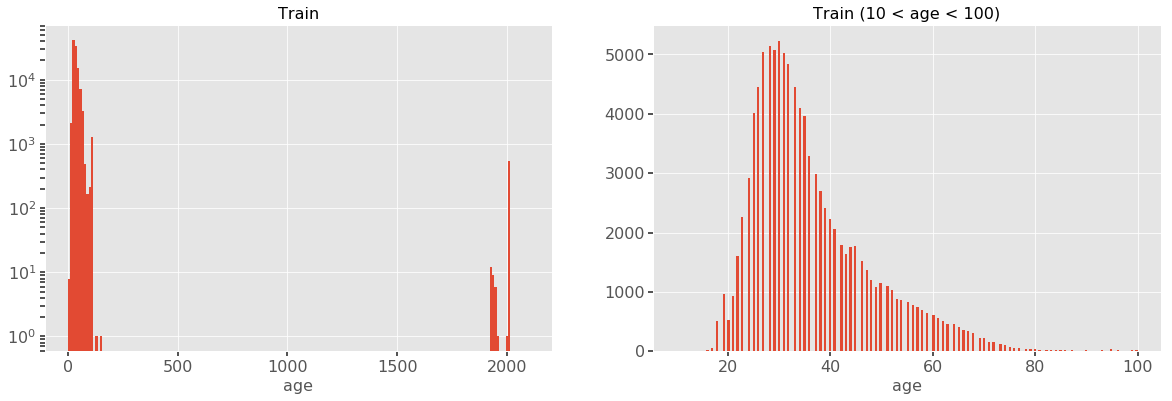

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6), sharex = False, sharey = False)
ax[0].hist(users_data.age, range = (0, 2100), log = True, bins = 200, normed = False);
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_title('Train', fontsize = 16);
ax[0].set_xlabel('age', fontsize = 16);
ax[1].hist(users_data.age, range = (10, 100), log = False, bins = 200, normed = False);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_title('Train (10 < age < 100)', fontsize = 16);
ax[1].set_xlabel('age', fontsize = 16);

##### `age` & `Booking`

In [14]:
users_data.loc[:,['age', 'Booking']].groupby('Booking').describe()

age                                                      
           count       mean         std  min   25%   50%   75%     max
Booking                                                               
0        48104.0  49.439714  153.133448  1.0  28.0  34.0  44.0  2014.0
1        57279.0  46.528745  138.287963  2.0  28.0  33.0  41.0  2014.0

*Finding: Median ages for users that made a booking (`age` = 33) and those made no booking (`age` = 34) are similar. However, distribution of no-booking users has higher mean age (`age` ~ 49) than mean age for users with booking (`age` ~ 47)*

#### Select valid `age` entries

In [16]:
valid_age_index = users_data.age.apply(lambda x: 10 < x < 100)

#### Impute missing/invalid `age` with 10000

In [17]:
users_data.loc[~valid_age_index, 'age'] = 0

#### Log transform `age`

In [18]:
# compute skewness
users_data.age.skew()

0.41051044012983801

In [19]:
users_data.loc[:,'age'] = np.log1p(users_data.age)

#### standardize `age`

In [20]:
standardizer = StandardScaler()
users_data.loc[:, 'age'] = standardizer.fit_transform(users_data.age.values.reshape(-1, 1))

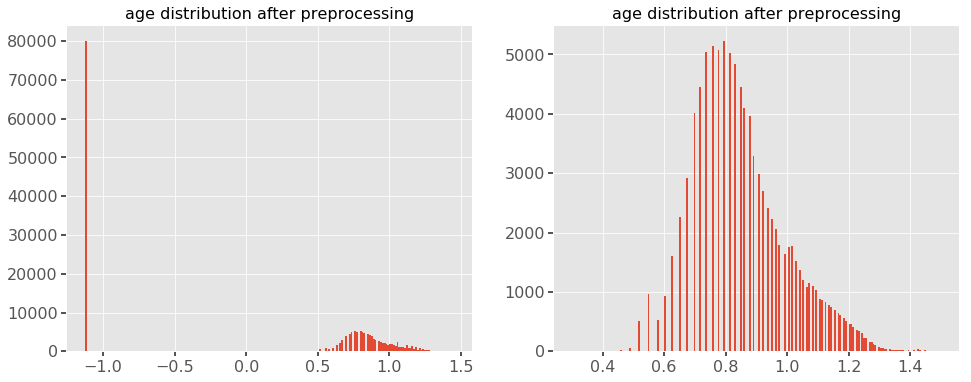

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6), sharex = False, sharey = False)

ax[0].hist(users_data.age, log = False, bins = 200, normed = False);
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_title('age distribution after preprocessing', fontsize = 16);

ax[1].hist(users_data.age, range = (0.3, 1.5), log = False, bins = 200, normed = False);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_title('age distribution after preprocessing', fontsize = 16);

#### Categorical features & `Booking`

In [22]:
cat_features = users_data.columns.tolist()
cat_features = [i for i in cat_features if i not in ('Booking', 'id', 'age', 'date_account_created', 'timestamp_first_active')]
print('Total number of categorical features: {}'.format(len(cat_features)))
print('They are:', cat_features)

Total number of categorical features: 3
They are: ['gender', 'affiliate_channel', 'signup_app']


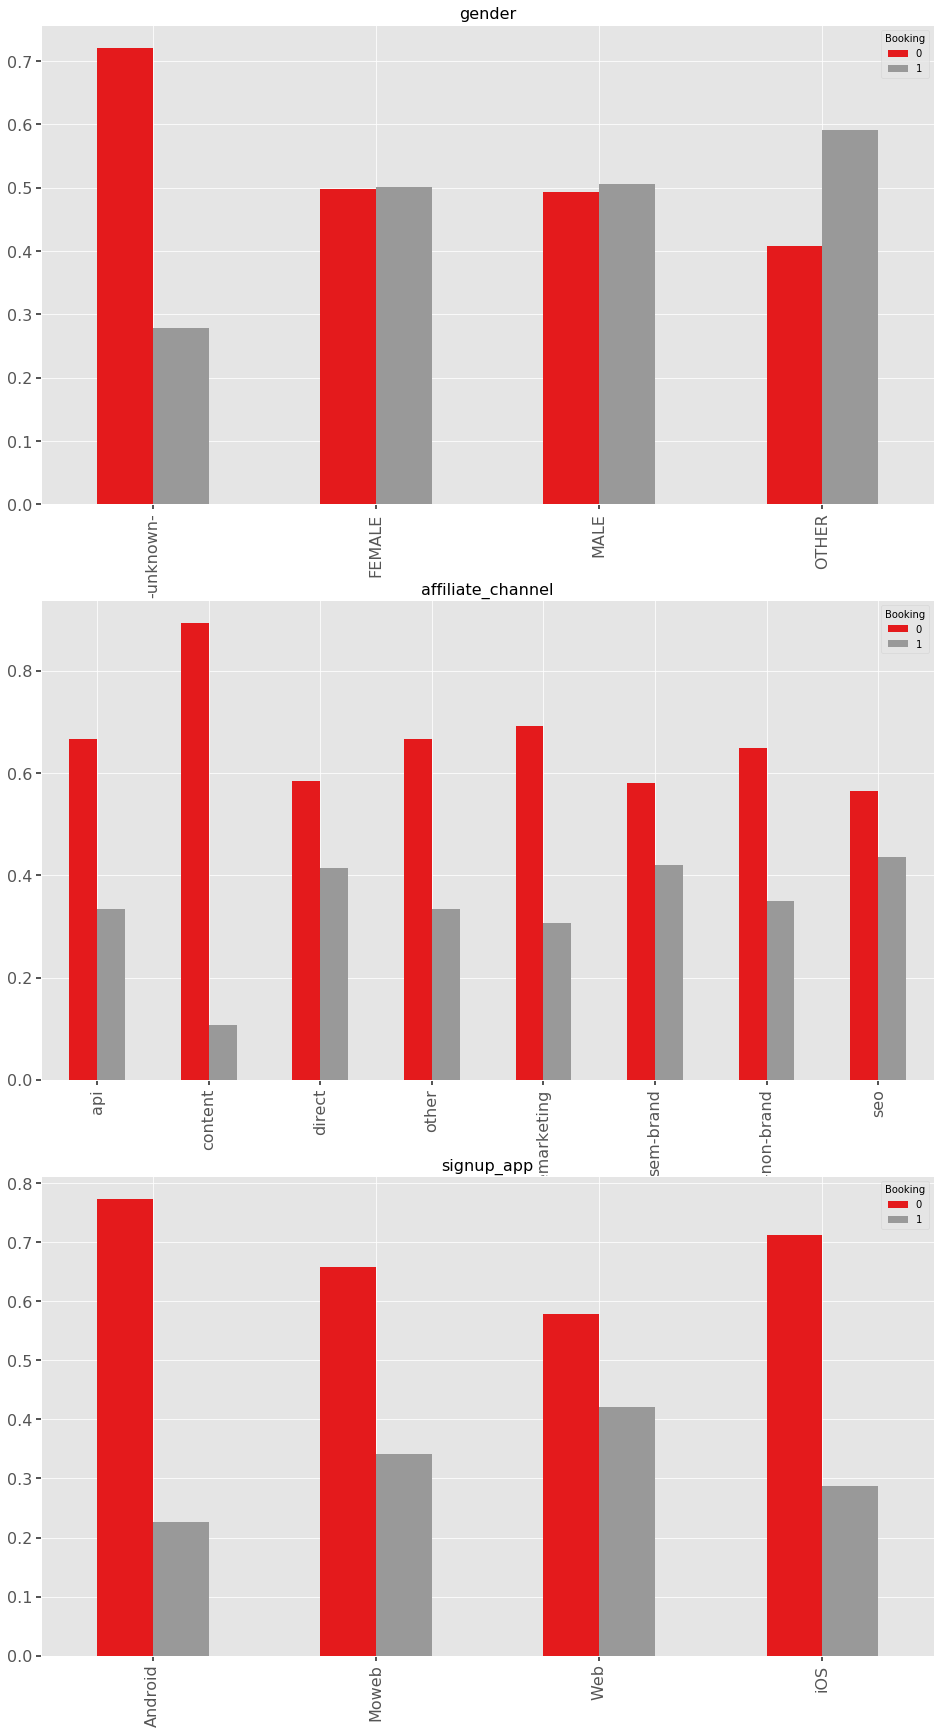

In [23]:
bar_order = users_data['Booking'].value_counts().index.tolist()
fig = plt.figure(figsize = (16, 30));

i = 1
for feat in cat_features:
    cross_tab = pd.crosstab(users_data.Booking, [users_data.loc[:,feat]])
    ax = fig.add_subplot(len(cat_features), 1, i);
    
    ax.tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
    tmp = pd.crosstab([users_data.loc[:,feat]], users_data.Booking).apply(lambda x: x/x.sum(), axis=1)
    tmp.plot(kind='bar', stacked=False, ax = ax, legend = True, colormap = 'Set1');
    ax.set_xlabel('');
    ax.set_title(feat, fontsize = 16);
    i += 1

#### Label encode categorical features

In [24]:
feat_code_map = dict()
for feat in cat_features:
    users_data.loc[:, feat] = label_encoder.fit_transform(users_data[feat])
    feat_code_map[feat]=dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

#### One-hot encode categorical features

In [25]:
one_hot_encoder = OneHotEncoder(sparse = True)
users_cat_data = one_hot_encoder.fit_transform(users_data[cat_features])
print (users_cat_data.shape)

(183537, 16)


#### Convert datetime column into the correct data type

In [26]:
users_data.loc[:,'date_account_created'] = pd.to_datetime(users_data.date_account_created)

#### Extract features from datetime columns

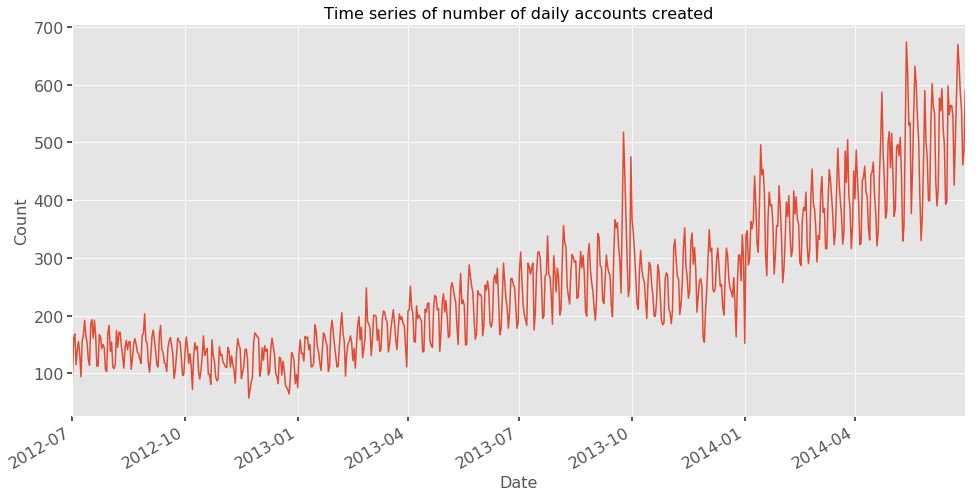

In [27]:
fig, ax = plt.subplots(figsize = (16, 8));
users_data.date_account_created.value_counts().plot();
ax.tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax.set_title('Time series of number of daily accounts created', fontsize = 16);
ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Count', fontsize = 16);

##### Year, month, day in month, day in week, holiday features

In [28]:
users_data['year_account_created'] = users_data.date_account_created.apply(lambda x: x.year)
users_data['month_account_created'] = users_data.date_account_created.apply(lambda x: x.month)
users_data['dayinmonth_account_created'] = users_data.date_account_created.apply(lambda x: x.day)
# Monday is 1 and Sunday is 7
users_data['dayinweek_account_created'] = users_data.date_account_created.apply(lambda x: x.isoweekday())

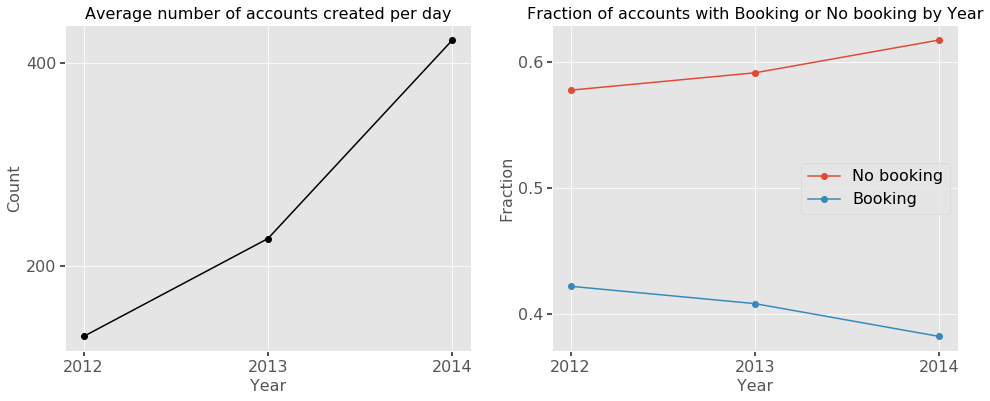

In [29]:
bookings_byyear = users_data.loc[:, ['Booking', 'year_account_created']].groupby(['year_account_created','Booking']).size().unstack('Booking')
bookings_byyear['total'] = bookings_byyear.iloc[:, 0] + bookings_byyear.iloc[:, 1]
bookings_byyear['no_booking_fraction'] = bookings_byyear.iloc[:, 0] / bookings_byyear['total']
bookings_byyear['booking_fraction'] = bookings_byyear.iloc[:, 1] / bookings_byyear['total']
bookings_byyear['number_of_days'] = users_data.loc[:, ['date_account_created', 'year_account_created']]\
                                       .groupby(['year_account_created']).nunique().loc[:,'date_account_created']
bookings_byyear['avg_account_per_day'] = bookings_byyear.total / bookings_byyear.number_of_days


fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_byyear.avg_account_per_day, 'o-', color = 'black');
ax[0].set_title('Average number of accounts created per day', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Year', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);
ax[0].locator_params(nbins = 3);

ax[1].plot(bookings_byyear.no_booking_fraction, 'o-', label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Year', fontsize = 16)
ax[1].plot(bookings_byyear.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Year', fontsize = 16);
ax[1].set_ylabel('Fraction', fontsize = 16);
ax[1].locator_params(nbins = 3);

*Findings:*
- Average number of accounts per day increases from 2012 to 2014.
- However, the fraction of users who made a booking decreases slightly over the same period of time.

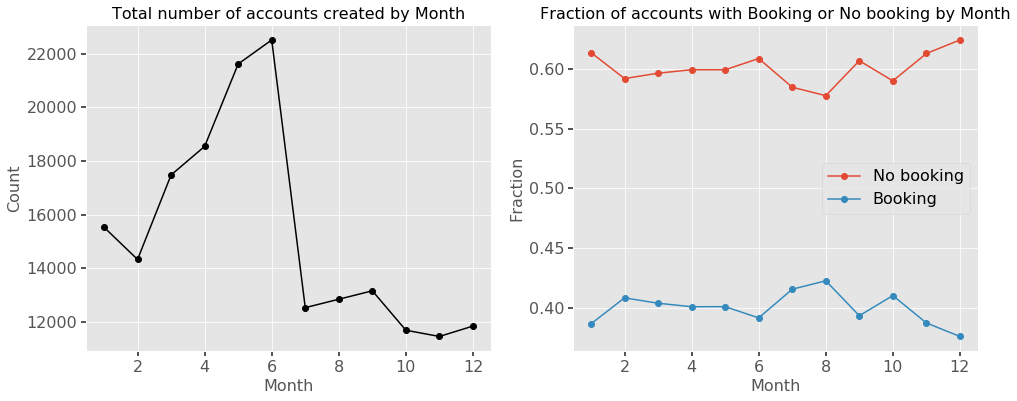

In [30]:
bookings_bymonth = users_data.loc[:, ['Booking', 'month_account_created']].groupby(['month_account_created','Booking']).size().unstack('Booking')
bookings_bymonth['total'] = bookings_bymonth.iloc[:, 0] + bookings_bymonth.iloc[:, 1]
bookings_bymonth['no_booking_fraction'] = bookings_bymonth.iloc[:, 0] / bookings_bymonth['total']
bookings_bymonth['booking_fraction'] = bookings_bymonth.iloc[:, 1] / bookings_bymonth['total']

fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_bymonth.total, 'o-', color = 'black');
ax[0].set_title('Total number of accounts created by Month', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Month', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);

ax[1].plot(bookings_bymonth.no_booking_fraction, 'o-', label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Month', fontsize = 16)
ax[1].plot(bookings_bymonth.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Month', fontsize = 16);
ax[1].set_ylabel('Fraction', fontsize = 16);

*Findings:*
- In terms of total number of accounts created, June is highest, which is almost twice as the lowest month (Nov).
- In terms of the fraction of users who made a booking, the monthly variation is not that large. July and August are slightly higher.

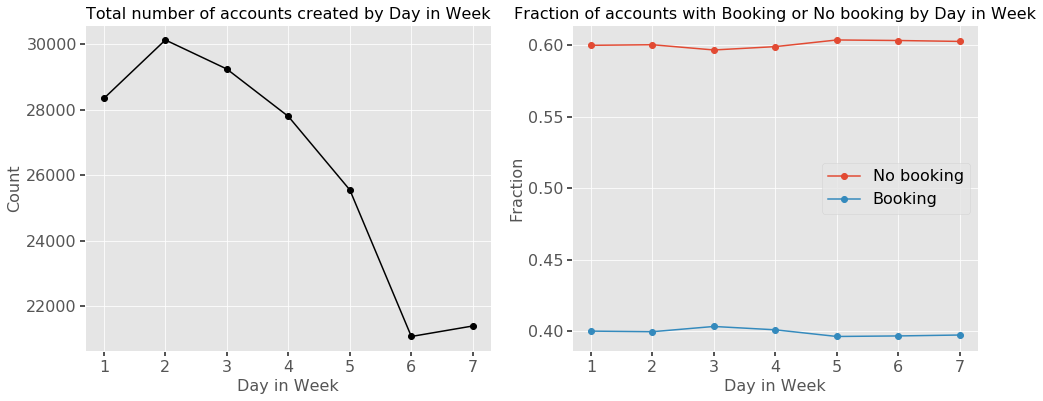

In [31]:
bookings_bydayinweek = users_data.loc[:, ['Booking', 'dayinweek_account_created']].groupby(['dayinweek_account_created','Booking']).size().unstack('Booking')
bookings_bydayinweek['total'] = bookings_bydayinweek.iloc[:, 0] + bookings_bydayinweek.iloc[:, 1]
bookings_bydayinweek['no_booking_fraction'] = bookings_bydayinweek.iloc[:, 0] / bookings_bydayinweek['total']
bookings_bydayinweek['booking_fraction'] = bookings_bydayinweek.iloc[:, 1] / bookings_bydayinweek['total']

fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_bydayinweek.total, 'o-', color = 'black');
ax[0].set_title('Total number of accounts created by Day in Week', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Day in Week', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);

ax[1].plot(bookings_bydayinweek.no_booking_fraction, 'o-', label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Day in Week', fontsize = 16)
ax[1].plot(bookings_bydayinweek.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Day in Week', fontsize = 16);
ax[1].set_ylabel('Fraction', fontsize = 16);

*Findings:*
- Tuesday is the day of week most users sign up for account on Airbnb. Saturday has least number of users create accounts.
- The fraction of users who made a booking is almost constant in terms of the day in week.

In [32]:
users_data.drop('dayinweek_account_created', axis = 1, inplace = True)

In [33]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start = users_data.date_account_created.min(), 
                        end = users_data.date_account_created.max())

users_data['Holiday'] = users_data.date_account_created.isin(holidays)

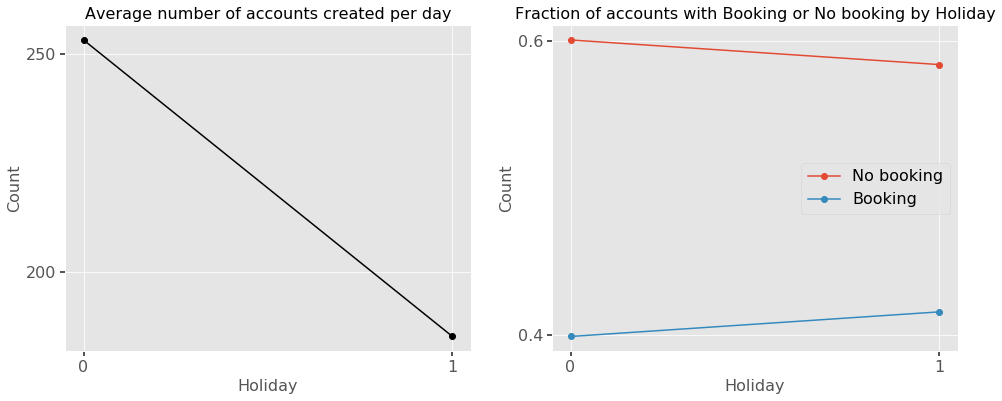

In [34]:
bookings_byholiday = users_data.loc[:, ['Booking', 'Holiday']].groupby(['Holiday','Booking']).size().unstack('Booking')
bookings_byholiday['total'] = bookings_byholiday.iloc[:, 0] + bookings_byholiday.iloc[:, 1]
bookings_byholiday['no_booking_fraction'] = bookings_byholiday.iloc[:, 0] / bookings_byholiday['total']
bookings_byholiday['booking_fraction'] = bookings_byholiday.iloc[:, 1] / bookings_byholiday['total']
bookings_byholiday['number_of_days'] = users_data.loc[:, ['date_account_created', 'Holiday']]\
                                       .groupby(['Holiday']).nunique().loc[:,'date_account_created']
bookings_byholiday['avg_account_per_day'] = bookings_byholiday.total / bookings_byholiday.number_of_days
fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_byholiday.avg_account_per_day, 'o-', color = 'k');
ax[0].set_title('Average number of accounts created per day', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Holiday', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);
ax[0].locator_params(nbins = 2);

ax[1].plot(bookings_byholiday.no_booking_fraction, 'o-',label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Holiday', fontsize = 16)
ax[1].plot(bookings_byholiday.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Holiday', fontsize = 16);
ax[1].set_ylabel('Count', fontsize = 16);
ax[1].locator_params(nbins = 2);

*Finding:*
- Less people sign up accounts on US holidays than on other days.
- The fraction of users who made a booking on holiday is slightly higher than on other days.

#### Label & One-hot encode datetime features

In [35]:
datetime_features = ['year_account_created', 'month_account_created', 'dayinmonth_account_created', 'Holiday']
# Label encode
for feat in datetime_features:
    users_data.loc[:, feat] = label_encoder.fit_transform(users_data[feat])
    feat_code_map[feat] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# One-hot encode
users_datetime_data = one_hot_encoder.fit_transform(users_data[datetime_features])
print (users_datetime_data.shape)

(183537, 48)


### 5. Build a predictive model

Be careful not to overfit!

In [36]:
full_data_sparse = sparse.hstack((users_cat_data, 
                                  users_datetime_data, 
                                  np.array(users_data['age'])[:, None]), 
                                 format='csr')
print ("Check number of columns: ", full_data_sparse.shape[1], "==", 
       users_cat_data.shape[1] + users_datetime_data.shape[1] + 1)

Check number of columns:  65 == 65


#### Split train and test data

In [37]:
target = users_data['Booking']

In [38]:
# Split the features and target data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_data_sparse, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 146829 samples.
Testing set has 36708 samples.


#### Build a logistic regression model

In [158]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# class_weight = “balanced”: adjust weights inversely proportional to class frequencies in the input data 
logistic_reg =  LogisticRegression(class_weight = 'balanced', verbose = 10, random_state = 0)

# smaller values specify stronger regularization
parameter_candidates = [{'C':[1e-3, 1e-2, 1e-1], 
                         'penalty':['l1','l2']}]

models = GridSearchCV(estimator = logistic_reg, 
                      param_grid = parameter_candidates,
                      scoring = ['accuracy', 'f1'],
                      cv = 5,
                      n_jobs = -1,
                      verbose = 10,
                      refit = 'f1')

models.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001, penalty=l1 .............................................
[CV] C=0.001, penalty=l1 .............................................
[CV] C=0.001, penalty=l1 .............................................
[CV] C=0.001, penalty=l1 .............................................
[LibLinear][CV]  C=0.001, penalty=l1, f1=0.6363990785043416, accuracy=0.650650412041136, total=   0.4s
[CV] C=0.001, penalty=l1 .............................................
[LibLinear][CV]  C=0.001, penalty=l1, f1=0.6386156132776559, accuracy=0.6522509024041409, total=   0.5s
[CV] C=0.001, penalty=l2 .............................................
[LibLinear][CV]  C=0.001, penalty=l1, f1=0.6360606920022689, accuracy=0.6504120411360076, total=   0.5s
[CV] C=0.001, penalty=l2 .............................................
[LibLinear][CV]  C=0.001, penalty=l1, f1=0.6314563928873835, accuracy=0.6442825035755636, total=   0.8s
[CV] C=0.001, penalty=l2 ...

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[LibLinear][CV]  C=0.001, penalty=l2, f1=0.6323349852761617, accuracy=0.6513655247565211, total=   0.7s
[CV] C=0.001, penalty=l2 .............................................
[LibLinear][CV]  C=0.001, penalty=l2, f1=0.635968722849696, accuracy=0.6575631682898591, total=   0.7s
[CV] C=0.01, penalty=l1 ..............................................
[LibLinear][CV]  C=0.001, penalty=l2, f1=0.6386682074245269, accuracy=0.6592658176122046, total=   0.7s
[CV] C=0.01, penalty=l1 ..............................................
[LibLinear][CV]  C=0.001, penalty=l2, f1=0.6339904876012055, accuracy=0.6567118436286863, total=   0.7s
[CV] C=0.01, penalty=l1 ..............................................
[LibLinear][CV]  C=0.001, penalty=l2, f1=0.6334429547179358, accuracy=0.6545887961859357, total=   0.8s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s


[LibLinear][CV]  C=0.01, penalty=l1, f1=0.6383959606307855, accuracy=0.6634543349451747, total=   5.3s
[CV] C=0.01, penalty=l1 ..............................................
[LibLinear][CV]  C=0.01, penalty=l1, f1=0.6328579743888243, accuracy=0.6563372607777702, total=   6.6s
[CV] C=0.01, penalty=l2 ..............................................
[LibLinear][CV]  C=0.01, penalty=l2, f1=0.6305896174462149, accuracy=0.6573588503711776, total=   1.8s
[CV] C=0.01, penalty=l2 ..............................................
[LibLinear][CV]  C=0.01, penalty=l1, f1=0.6358525921299188, accuracy=0.6625008513246612, total=   7.9s
[CV] C=0.01, penalty=l2 ..............................................
[LibLinear][CV]  C=0.01, penalty=l1, f1=0.6359338927773095, accuracy=0.6616835796499353, total=   9.4s
[CV] C=0.01, penalty=l2 ..............................................
[LibLinear][CV]  C=0.01, penalty=l2, f1=0.6329993715109615, accuracy=0.6619560035415106, total=   1.3s
[LibLinear][CV]  C=0.01, pe

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.4s


[LibLinear][CV]  C=0.01, penalty=l2, f1=0.6318601803406434, accuracy=0.6621603214601921, total=   1.1s
[CV] C=0.1, penalty=l1 ...............................................
[LibLinear][CV]  C=0.01, penalty=l2, f1=0.6329244864784985, accuracy=0.661638004427039, total=   1.4s
[CV] C=0.1, penalty=l1 ...............................................
[LibLinear][CV]  C=0.01, penalty=l1, f1=0.6345745848269807, accuracy=0.6597990805380555, total=   6.1s
[CV] C=0.1, penalty=l1 ...............................................
[LibLinear][CV]  C=0.1, penalty=l1, f1=0.6353480801953096, accuracy=0.6643056596063475, total=  11.4s
[CV] C=0.1, penalty=l1 ...............................................
[LibLinear][CV]  C=0.1, penalty=l1, f1=0.6326001629267569, accuracy=0.6621262684737451, total=  18.3s
[CV] C=0.1, penalty=l2 ...............................................
[LibLinear][CV]  C=0.1, penalty=l1, f1=0.6312267657992565, accuracy=0.662194374446639, total=  17.5s
[CV] C=0.1, penalty=l2 .........

[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   34.9s remaining:    3.9s


[LibLinear][CV]  C=0.1, penalty=l2, f1=0.6306152071160073, accuracy=0.6620241095144044, total=   1.4s
[LibLinear][CV]  C=0.1, penalty=l2, f1=0.631957044991668, accuracy=0.6615358419887621, total=   1.3s
[LibLinear][CV]  C=0.1, penalty=l1, f1=0.6323730631263637, accuracy=0.6614677336965775, total=  12.1s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   37.8s finished


[LibLinear]CPU times: user 5.13 s, sys: 294 ms, total: 5.43 s
Wall time: 41.7 s


In [159]:
# best f1 score
models.best_score_

0.66147014554345529

In [160]:
# best combination of parameters
models.best_params_

{'C': 0.1, 'penalty': 'l1'}

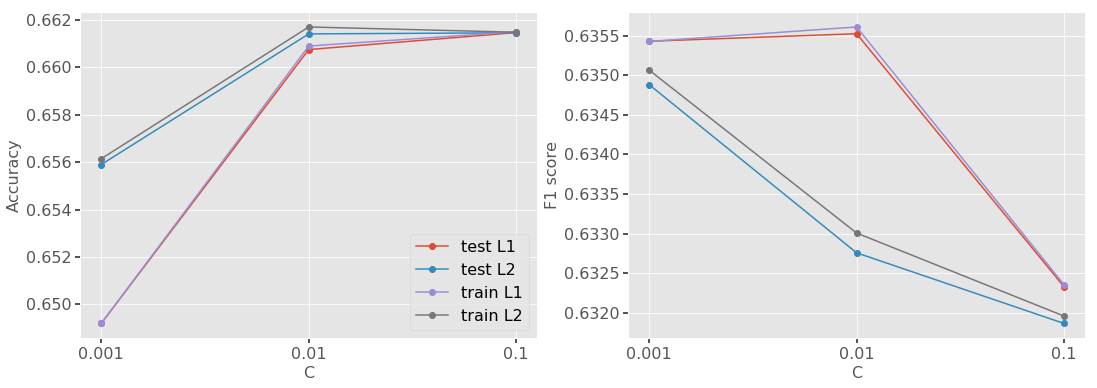

In [157]:
fig, ax = plt.subplots(ncols = 2, figsize = (18, 6))

l1_ind = [0, 2, 4]; l2_ind = [1, 3, 5]

ax[0].plot(l1_ind, models.cv_results_['mean_test_accuracy'][l1_ind], 'o-', label = 'test L1');
ax[0].plot(l1_ind, models.cv_results_['mean_test_accuracy'][l2_ind], 'o-', label = 'test L2');
ax[0].plot(l1_ind, models.cv_results_['mean_train_accuracy'][l1_ind], 'o-', label = 'train L1');
ax[0].plot(l1_ind, models.cv_results_['mean_train_accuracy'][l2_ind], 'o-', label = 'train L2');
ax[0].set_xticklabels([0.001, 0.01, 0.1]);
ax[0].set_xticks(l1_ind);
ax[0].set_xlabel('C', fontsize = 16);
ax[0].set_ylabel('Accuracy', fontsize = 16);
ax[0].legend(fontsize = 16);
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
#ax[0].axhline(y = accuracy_naive, color = 'k');

ax[1].plot(l1_ind, models.cv_results_['mean_test_f1'][l1_ind], 'o-', label = 'test L1');
ax[1].plot(l1_ind, models.cv_results_['mean_test_f1'][l2_ind], 'o-', label = 'test L2');
ax[1].plot(l1_ind, models.cv_results_['mean_train_f1'][l1_ind], 'o-', label = 'train L1');
ax[1].plot(l1_ind, models.cv_results_['mean_train_f1'][l2_ind], 'o-', label = 'train L2');
ax[1].set_xticklabels([0.001, 0.01, 0.1]);
ax[1].set_xticks(l1_ind);
ax[1].set_xlabel('C', fontsize = 16);
ax[1].set_ylabel('F1 score', fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
#ax[1].axhline(y = f1_naive, color = 'k');

Compared with the naive predictor, which has `Accuracy ~ 0.60` and `F1 ~ 0.75`, the best logistic regression model we found above has a slightly better `Accuracy ~ 0.66` and a worse `F1 ~ 0.64`.

#### Evaluate the best model on test data

In [144]:
# F1 score on test data
models.score(X_test, y_test)

0.63383372838205598

### Conclusion

Since we chose `F1 score` as metrics, the logistic regression model we built above is not better than a naive predictor which always predict no booking for all users. However a naive predictor doesn't provide us with any information about the data.

However, if we use `Accuracy` as metrics, the logistic regression model is good and achieves `Accuracy >~ 0.66` on both training and testing data during cross validation for C = 0.01 or 0.1. 

This means that the goal of this demo is not easily achieved with the input data. One way to improve is to gather more attributes for each users and use more sophisticated machine learning algorithm, like tree based models to allow nonlinearity in the model.